In [58]:
from utils import Config
config_con = Config("/home/onion/conclr/configs/conclr_pretrain_vision_model.yaml")
config_abi = Config("/home/onion/conclr/configs/pretrain_vision_model.yaml")

In [59]:
from dataset import ImageLMDBDataset
from utils import MyConcatDataset
from torch.utils.data import DataLoader
def get_dataset(ds_type, paths, is_training, config, **kwargs):
    kwargs.update(
        {
            "img_h": config.dataset_image_height,
            "img_w": config.dataset_image_width,
            "max_length": config.dataset_max_length,
            "case_sensitive": config.dataset_case_sensitive,
            "charset_path": config.dataset_charset_path,
            "data_aug": config.dataset_data_aug,
            "deteriorate_ratio": config.dataset_deteriorate_ratio,
            "is_training": is_training,
            "multiscales": config.dataset_multiscales,
            "one_hot_y": config.dataset_one_hot_y,
            "use_conclr": config.global_conclr,
        }
    )
    datasets = [ds_type(p, **kwargs) for p in paths]
    if len(datasets) > 1:
        return MyConcatDataset(datasets)
    else:
        return datasets[0]

ds = get_dataset(ImageLMDBDataset, config_con.dataset_test_roots, True, config_con)
data_loader = DataLoader(ds, 256)

In [60]:
from utils import CharsetMapper
charset = CharsetMapper('data/charset_36.txt')

In [61]:
import os
import torch
from modules.model_vision import BaseVision
from modules.model_conclr_vision import ConCLR_Vision

def load(model, file, device=None, strict=True):
    if device is None: device = 'cpu'
    elif isinstance(device, int): device = torch.device('cuda', device)
    assert os.path.isfile(file)
    state = torch.load(file, map_location=device)
    if set(state.keys()) == {'model', 'opt'}:
        state = state['model']
    model.load_state_dict(state, strict=strict)
    return model

conclr_abinet = load(ConCLR_Vision(config_con), config_con.model_checkpoint, device=0).eval()
base_abinet = load(BaseVision(config_abi), config_abi.model_checkpoint, device=0).eval()


In [62]:
import torch.nn.functional as F
def decode(logit, charset, max_length):
    """Greed decode"""
    out = F.softmax(logit, dim=1)
    text = charset.get_text(out.argmax(dim=1), padding=False, trim=False)
    text = text.split(charset.null_char)[0]  # end at end-token
    pt_text = text
    return pt_text

In [63]:
base_embed, conclr_embed, character_labels = [],[],[]
with torch.no_grad():
    for i, sample in enumerate(data_loader):
        input, (gt, gt_length) = sample
        conclr_feats = conclr_abinet.backbone(input)
        conclr_attn, _ = conclr_abinet.attention(conclr_feats)
        conclr_logits = conclr_abinet.cls(conclr_attn)
        base_feats = base_abinet.backbone(input)
        base_attn, _ = base_abinet.attention(base_feats)
        base_logits = base_abinet.cls(base_attn)
        for i in range(len(gt)):
            text = charset.get_text(torch.argmax(gt[i], dim=1), padding=False)
            # pt = decode(conclr_logits[i], charset, config_con.dataset_max_length)
            for j in range(len(text)):
                if text[j] in 'ghypf':
                    base_embed.append(conclr_attn[i][j].cpu())
                    conclr_embed.append(base_attn[i][j].cpu())
                    character_labels.append(text[j])
        if len(character_labels) >= 40000:
            break
base_embed = torch.stack(base_embed)
conclr_embed = torch.stack(conclr_embed)


In [70]:
from sklearn.manifold import TSNE
tsne_base = TSNE(n_components=2, random_state=202)
tsne_base_embed = tsne_base.fit_transform(base_embed.cpu().numpy())

tsne_conclr = TSNE(n_components=2, random_state=202)
tsne_conclr_embed = tsne_conclr.fit_transform(conclr_embed.cpu().numpy())

In [71]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def plot_embeddings(embeddings1, embeddings2, labels):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    for embeddings, ax, title in [(embeddings1, ax1, 'abinet-embedding'), (embeddings2, ax2, 'conclr-embedding')]:
        char_points = {label: [] for label in set(labels)}
        
        for i, (x, y) in enumerate(embeddings):
            c = labels[i]
            char_points[c].append([x, y])
        
        for c, points in char_points.items():
            if points:
                points = np.array(points)
                ax.scatter(points[:, 0], points[:, 1], label=c, s=10)
        
        ax.set_title(title)
        ax.legend()
    
    plt.tight_layout()
    plt.show()


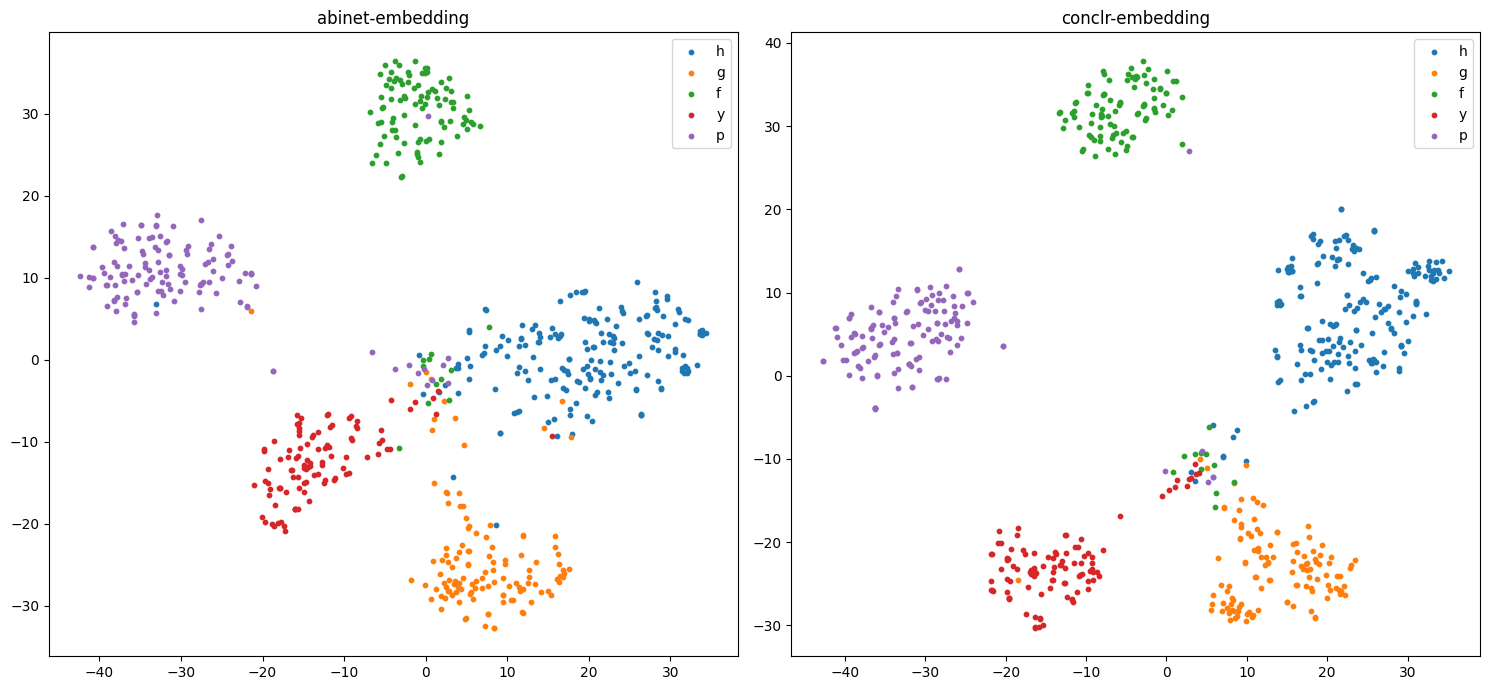

In [72]:
plot_embeddings(tsne_base_embed, tsne_conclr_embed, character_labels)

In [73]:
from sklearn.manifold import TSNE
tsne_base = TSNE(n_components=3, random_state=202)
tsne_base_embed = tsne_base.fit_transform(base_embed.cpu().numpy())

tsne_conclr = TSNE(n_components=3, random_state=202)
tsne_conclr_embed = tsne_conclr.fit_transform(conclr_embed.cpu().numpy())

In [74]:
import numpy as np
import matplotlib.pyplot as plt

def plot_embeddings_3d(embeddings1, embeddings2, labels):
    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    
    for embeddings, ax, title in [(embeddings1, ax1, 'abinet-embedding'), (embeddings2, ax2, 'conclr-embedding')]:
        char_points = {label: [] for label in set(labels)}
        
        for i, (x, y, z) in enumerate(embeddings):
            c = labels[i]
            char_points[c].append([x, y, z])
        
        for c, points in char_points.items():
            if points:
                points = np.array(points)
                ax.scatter(points[:, 0], points[:, 1], points[:, 2], label=c, s=10)
        
        ax.set_title(title)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

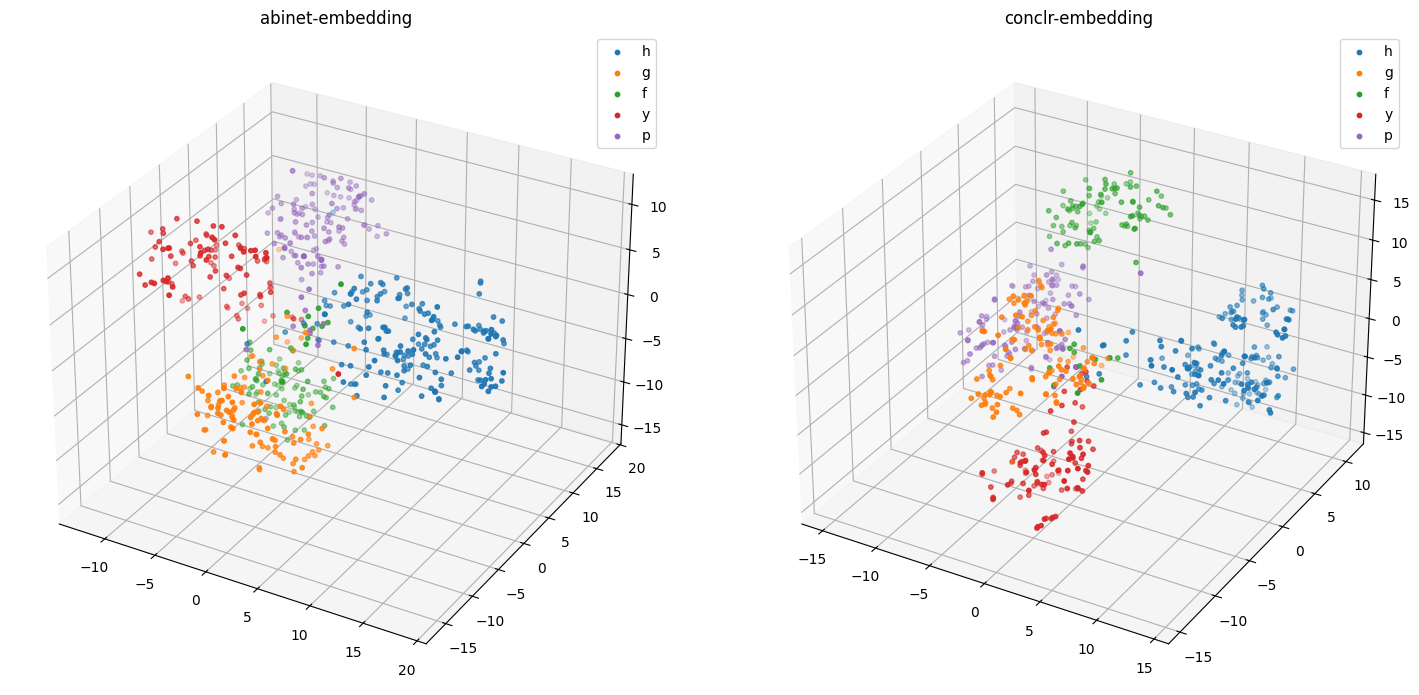

In [75]:
plot_embeddings_3d(tsne_base_embed, tsne_conclr_embed, character_labels)